## Analyze A/B Test Results

This project is a part of Udacity Data Analyst Nanodegree. It was structured in Question-Answer format. I left the questions asked in unedited state to help understanding the process of the project. 


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [155]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [156]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [157]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [158]:
df_drop_dup = df.drop_duplicates(subset='user_id')
df_drop_dup['user_id'][df_drop_dup['converted']==1].count()/df_drop_dup['user_id'].count()

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't match.

In [159]:
a = df['user_id'][(df['group']=='treatment')&(df['landing_page']=='old_page')].count()
b = df['user_id'][(df['group']=='control')&(df['landing_page']=='new_page')].count()
print('The number of times the new_page and treatment do not match -',a+b)

The number of times the new_page and treatment do not match - 3893


f. Do any of the rows have missing values?

In [160]:
df.info() #no rows with missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [161]:
df2 = df[((df['group']=='treatment')&(df['landing_page']=='new_page'))|((df['group']=='control')&(df['landing_page']=='old_page'))] 

In [162]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3`

a. How many unique **user_id**s are in **df2**?

In [163]:
df2['user_id'].count()

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [164]:
dup_user = df2['user_id'][df2['user_id'].duplicated()].values.tolist()
dup_user[0]

773192

c. What is the row information for the repeat **user_id**? 

In [165]:
df2[df2['user_id']==dup_user[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [166]:
indexes = df2[df2['user_id']==dup_user[0]].index.tolist()
index_drop = indexes[1]
df2 = df2.drop(indexes[1])

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [167]:
df2['user_id'][df['converted']==1].count()/df2['user_id'].count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [168]:
df2['user_id'][(df2['group']=='control')&(df2['converted']==1)].count()/df2['user_id'][df2['group']=='control'].count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [169]:
df2['user_id'][(df2['group']=='treatment')&(df2['converted']==1)].count()/df2['user_id'][df2['group']=='treatment'].count()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [170]:
df2['user_id'][df2['landing_page']=='new_page'].count()/df2['user_id'].count()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<b>Answer:</b> The probability of an individual from the control group converting is higher than the probability of an individual from the treatment group converting. Intuitively, this means that the old page is more appealing to the users than the new one. So far, there is definetely not enough evidence to conclude that the new page leads to more conversions, in fact it happens to be the other way around.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$**: **$p_{old}$** >= **$p_{new}$** <p>
**$H_{1}$**: **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [171]:
p_new = df2['user_id'][df2['converted']==1].count()/(df2['user_id'].count())
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [172]:
p_old = df2['user_id'][df2['converted']==1].count()/(df2['user_id'].count())
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [173]:
n_new = df2['user_id'][df2['group']=='treatment'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [174]:
n_old = df2['user_id'][df2['group']=='control'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [175]:
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17457

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [176]:
old_page_converted = np.random.binomial(n_old,p_old)
old_page_converted

17472

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [177]:
diff = (new_page_converted/n_new)-(old_page_converted/n_old)
diff

-0.00013302384029294234

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [178]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old,p_old)
    diff = (new_page_converted/n_new)-(old_page_converted/n_old)
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

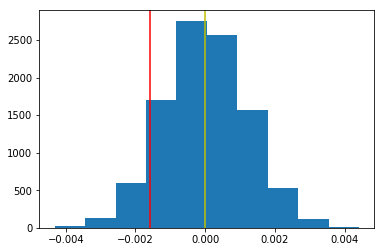

In [179]:
p_diffs = np.array(p_diffs)
p_new_obs = df2['user_id'][(df2['converted']==1)&(df2['group']=='treatment')].count()/df2['user_id'][df2['group']=='treatment'].count()
p_old_obs = df2['user_id'][(df2['converted']==1)&(df2['group']=='control')].count()/df2['user_id'][df2['group']=='control'].count()
actual = p_new_obs - p_old_obs
plt.hist(p_diffs)
plt.axvline(actual,color='r')
plt.axvline(0.0,color='y')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [180]:
(p_diffs>actual).mean()

0.90880000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<b> Answer : </b> The value that I found in part j is called p-value, which is equal to the probability of obtaining the observed statistic given that the null hypothesis is true. The calculated value is way too large to reject the null hypothesis, so it is not very likely that the new page will be more successful than the old page and the final decision would be to stick to the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [181]:
import statsmodels.api as sm

convert_old = df2['user_id'][(df2['group']=='control')&(df2['converted']==1)].count()
convert_new = df2['user_id'][(df2['group']=='treatment')&(df2['converted']==1)].count()
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [182]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<b>Answer:</b> The p-value computed represents the probability of obtaining the observed statistic given that the null hypothesis is true. The results found in parts j and k are very close to each other, around 0.90. The z-score represents the number of standard deviations between the centre of the normal distribution and the observed value. The actual difference between the conversion rate for the new page and the conversion rate for the old page was 1.31 x standard deviation to the left of the mean difference under the null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<b>Answer:</b> Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [183]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

In [184]:
df2 = df2.rename(columns={'treatment':'ab_page'})

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [185]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [186]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        11:28:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

<b> Answer: </b> I got 0.190 for my p-value that is associated with ab_page. The result is not statistically significant, as it is above 0.05 (alpha), therefore we can conclude that the new page is not more effective than the old one. The null and alternative hypotheses associated with our regression model are **$H_{0}$**: **$p_{old}$** = **$p_{new}$** and **$H_{1}$**: **$p_{old}$** != **$p_{new}$** which means that we run a two-tailed test using regression, unlike the one-tailed test in Part II of this project. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<b>Answer:</b> Considering other factors in building a regression model can make the final model more realistic and accurate. However, when choosing additional factors it is vital to check for multicollinearity to avoid bringing in correlated features. Regression model should be built based features that are not related to each other and only have influnence on the dependent variable that we want to predict.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [187]:
countries = pd.read_csv('countries.csv')
final = countries.merge(df2,on='user_id')
final[['Canada','UK','US']] = pd.get_dummies(final['country'])
final_logit_mod = sm.Logit(final['converted'],final[['UK','US','intercept','ab_page']])

In [188]:
results = final_logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        11:28:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

<b>Answer:</b>I decided to calculate the actual conversion rate of each country. UK has the highest conversion rate in comparison to the USA and Canada, which is supported by the results found in regression. I chose Canada to be a baseline, as a result, an individual from the UK is 1.05 (5%) times more likely to convert than an individual from Canada. A person from the US is 1.04 (4%) times more likely to convert than a person from Canada. 

In [189]:
np.exp(0.0408)

1.0416437559600236

In [190]:
cr_us = final['user_id'][(final['country']=='US')&(final['converted']==1)].count()/final['user_id'][final['country']=='US'].count()
cr_uk = final['user_id'][(final['country']=='UK')&(final['converted']==1)].count()/final['user_id'][final['country']=='UK'].count()
cr_ca = final['user_id'][(final['country']=='CA')&(final['converted']==1)].count()/final['user_id'][final['country']=='CA'].count()
cr_us, cr_uk, cr_ca

(0.1195468006423762, 0.12059448568984076, 0.11531829781364232)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
final['US_ab_page'] = final['US']*final['ab_page']
final['UK_ab_page'] = final['UK']*final['ab_page']
final['CA_ab_page'] = final['Canada']*final['ab_page']
logit_mod = sm.Logit(final['converted'],final[['intercept','US_ab_page','UK_ab_page','US','UK','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        10:45:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

<b>Answer:</b> After adding the interaction terms to our model, all features seem to be statistically insignificant, as they have p-values above 0.05 (alpha). Overall, I can conclude that the company should keep the old page, because the introduction of a new page won't benefit the company based on the A-B testing carried out in this project.